In [1]:
here::i_am("Code/cluspropAnalysis/cluspropFigures/update_S5.ipynb")

here() starts at /accounts/projects/epurdom/singlecell/pop_data



In [2]:
library(dplyr)
library(ggplot2)
library(ggpubr)
library(here)
library(RColorBrewer)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
dist_to_tibble <- function(distance_matrix,dataset_name,program_name,distance_params){
    # TODO: Include distance params as covariates
    distance_tibble <- tibble::as_tibble(distance_matrix)
    # fill the diagonal and lower half of the distance matrix with NA to avoid duplicate data
    distance_tibble[lower.tri(distance_tibble,diag=T)] <- NA
    distance_tibble <- distance_tibble %>% dplyr::mutate(first_unit=as.factor(colnames(distance_tibble)))
    distance_tibble_long <- tidyr::pivot_longer(distance_tibble,cols=-c(first_unit),names_to="second_unit",names_transform=list(second_unit=as.factor),values_to="distance")
    distance_tibble_long <- tidyr::drop_na(distance_tibble_long,"distance")
    distance_tibble_long <- distance_tibble_long %>%
        dplyr::mutate(dataset = dataset_name, program = program_name,
            dim_reduction=as.factor(distance_params$dim_reduction),
            ndim = distance_params$ndim,
            metric = as.factor(distance_params$dist),
            dens = as.factor(distance_params$dens),
            n = distance_params$n, k=distance_params$k,
            num_components = as.factor(paste(distance_params$num_components,collapse="_")),
            varapp = distance_params$varapp, epapp = distance_params$epapp)
    # add missing columns with NA
    all_columns <- c("dataset","program","first_unit","second_unit","distance",
        "metric","dim_reduction","ndim","dens","n","k","num_components","varapp","epapp")
    missing_columns <- setdiff(all_columns,colnames(distance_tibble_long))
    distance_tibble_long[,missing_columns] <- NA
    distance_tibble_long <- distance_tibble_long %>% select(all_columns)

    return(distance_tibble_long)
}

In [4]:
grand_tibble <- readRDS(here::here("results","fig","publication_distance_tibble.Rds"))

In [5]:
# Add Hao's Fabre lung and liver data
load(here::here("results","BatchStudy","dist_mat_fabre_lung_update.Rda"))
fabreLung_GMM_PCA <- dist_mat_GMM_PCA
fabreLung_KNN_PCA <- dist_mat_KNN_PCA
rm("dist_mat_GMM_har_paper", "dist_mat_GMM_har_sample", "dist_mat_GMM_PCA",
    "dist_mat_KNN_har_paper", "dist_mat_KNN_har_sample", "dist_mat_KNN_PCA")

# Add Hao's Fabre lung and liver data
load(here::here("results","BatchStudy","dist_mat_fabre_liver_update.Rda"))
fabreLiver_GMM_PCA <- dist_mat_GMM_PCA
fabreLiver_KNN_PCA <- dist_mat_KNN_PCA
rm("dist_mat_GMM_har_paper", "dist_mat_GMM_har_sample", "dist_mat_GMM_PCA",
    "dist_mat_KNN_har_paper", "dist_mat_KNN_har_sample", "dist_mat_KNN_PCA")

In [6]:
fabreLung_GMM_PCA_tibble <- dist_to_tibble(fabreLung_GMM_PCA, dataset_name = "fabreLung", program_name = "default",
    distance_params = list(dim_reduction = as.factor("PC"), ndim = 10, dist = as.factor("KL"),
        dens = as.factor("GMM"), n = NA, k = NA, num_components = NA, varapp = FALSE, epapp = FALSE))
fabreLung_GMM_PCA_tibble[,"index"] <- as.factor(1)
fabreLung_GMM_PCA_tibble[,"batch_corr"] <- NA

fabreLung_KNN_PCA_tibble <- dist_to_tibble(fabreLung_KNN_PCA, dataset_name = "fabreLung", program_name = "default",
    distance_params = list(dim_reduction = as.factor("PC"), ndim = 10, dist = as.factor("KL"),
        dens = as.factor("KNN"), n = NA, k = 10, num_components = NA, varapp = FALSE, epapp = FALSE))
fabreLung_KNN_PCA_tibble[,"index"] <- as.factor(1)
fabreLung_KNN_PCA_tibble[,"batch_corr"] <- NA

fabreLiver_GMM_PCA_tibble <- dist_to_tibble(fabreLiver_GMM_PCA, dataset_name = "fabreLiver", program_name = "default",
    distance_params = list(dim_reduction = as.factor("PC"), ndim = 10, dist = as.factor("KL"),
        dens = as.factor("GMM"), n = NA, k = NA, num_components = NA, varapp = FALSE, epapp = FALSE))
fabreLiver_GMM_PCA_tibble[,"index"] <- as.factor(1)
fabreLiver_GMM_PCA_tibble[,"batch_corr"] <- NA

fabreLiver_KNN_PCA_tibble <- dist_to_tibble(fabreLiver_KNN_PCA, dataset_name = "fabreLiver", program_name = "default",
    distance_params = list(dim_reduction = as.factor("PC"), ndim = 10, dist = as.factor("KL"),
        dens = as.factor("KNN"), n = NA, k = 10, num_components = NA, varapp = FALSE, epapp = FALSE))
fabreLiver_KNN_PCA_tibble[,"index"] <- as.factor(1)
fabreLiver_KNN_PCA_tibble[,"batch_corr"] <- NA

newdata_tibble <- rbind(fabreLung_GMM_PCA_tibble, fabreLung_KNN_PCA_tibble, fabreLiver_GMM_PCA_tibble, fabreLiver_KNN_PCA_tibble)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(all_columns)

  # Now:
  data %>% select(all_of(all_columns))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [7]:
new_grand_tibble <- rbind(grand_tibble, newdata_tibble)

In [8]:
metric_name="KL"
grand_tibble <- new_grand_tibble

In [9]:
plot_tibble <- grand_tibble %>%                                      
    filter(!(dataset %in% c("wuBreastCancer"))) %>%
    mutate(distance = ifelse(is.na(sqrt(distance)),0,sqrt(distance))) %>% # take the root distance
    group_by(dataset,dim_reduction,dens,k,n) %>% # we only keep one trial per cross of these variables, the one with the highest file index
    mutate(first_index=dplyr::first(index)) %>%                  
    ungroup() %>%                                                
    filter(index == first_index) %>%                             
    mutate(Method = interaction(dim_reduction, dens, sep="_")) %>% # our groups
    mutate(Experiment = interaction(dataset, program, sep="_"))

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `distance = ifelse(is.na(sqrt(distance)), 0, sqrt(distance))`.
Caused by warning in `sqrt()`:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


In [10]:
pc_tibble <- plot_tibble %>% filter(dim_reduction=="PC")
pc_tibble_baseline <- pc_tibble %>% filter(dens=="GMM") %>% mutate(baseline_distance=distance) %>% select(baseline_distance)
pc_tibble_alt <- pc_tibble %>% filter(dens=="KNN")
pc_tibble <- cbind(pc_tibble_alt,pc_tibble_baseline)
pc_tibble <- arrange(pc_tibble, dataset)

In [11]:
scvi_tibble <- plot_tibble %>% filter(dim_reduction=="scvi")
scvi_tibble_baseline <- scvi_tibble %>% filter(dens=="GMM") %>% mutate(baseline_distance=distance) %>% select(baseline_distance)	
scvi_tibble_alt <- scvi_tibble %>% filter(dens=="KNN")
scvi_tibble <- cbind(scvi_tibble_alt,scvi_tibble_baseline)
scvi_tibble <- arrange(scvi_tibble, dataset)

In [12]:
dataset_final <- function(dataset){
    if (dataset == "arnonMelanoma"){
        return("Melanoma Tumor [Arnon et al. (2018)]")
    } else if (dataset == "chengRash12"){
        return("Rash Epidermis [Cheng et al. (2018)]")
    } else if (dataset == "fabreLiver"){
        return("Liver Fibrosis [Fabre et al. (2023)]")
    } else if (dataset == "fabreLung"){
        return("Lung Fibrosis [Fabre et al. (2023)]")
    } else if (dataset == "ledergorMyeloma"){
        return("Multiple Myeloma Blood Plasma [Ledergor et al. (2018)]")
    } else if (dataset == "liuRash31"){
        return("Rash Immune Cell [Liu et al. (2022)]")
    } else if (dataset == "melmsCOVIDLung"){
        return("COVID Lung Tissue [Melms et al. (2021)]")
    } else if (dataset == "pelkaCRC"){
        return("Colorectal Tumor [Pelka et al. (2021)]")
    } else if (dataset == "perezLupus"){
        return("Lupus PBMC (Perez et al. (2022)]")
    } else if (dataset == "stephensonCOVIDPBMC"){
        return("COVID PBMC [Stephenson et al. (2021)]")
    } else if (dataset == "yaoMouseBrain"){
        return("Mouse Brain Tissue [Yao et al. (2021)]")
    } else{
        return(as.character(dataset))
    }
}

In [13]:
distance_tibble_pc <- pc_tibble %>%
        mutate(`Dimensionality Reduction` = dim_reduction) %>%
        rowwise() %>%
        mutate(dataset_str = dataset_final(dataset)) %>%
        mutate(dataset = as.factor(dataset_str))

In [14]:
distance_tibble_scvi <- scvi_tibble %>%
        mutate(`Dimensionality Reduction` = dim_reduction) %>%
        rowwise() %>%
        mutate(dataset_str = dataset_final(dataset)) %>%
        mutate(dataset = as.factor(dataset_str))

In [15]:
pca_plot <- ggplot2::ggplot(distance_tibble_pc, aes(x=baseline_distance,y=distance)) +
    geom_point(color="#009E73", alpha = 0.20) +
    geom_abline(slope = 1, intercept = 0, linetype = "longdash") +
    facet_wrap(vars(dataset), ncol=2) +
    theme_bw() +
    geom_smooth(method="loess",se=FALSE, linetype = "dotdash", fill = "#CC79A7") +
    ggpubr::stat_cor(aes(label = ggplot2::after_stat(r.label)), color = "black",# geom = "label", 
             cor.coef.name = "R", r.accuracy = 0.01, size=12, label.x.npc = 0.7, label.y.npc=0.15)+
    labs(x = paste0("GMM Root Symmetric KL Divergence"),
         y = paste0("kNN Root Symmetric KL Divergence")) +
    theme(axis.title.x = element_text(size = 32), axis.text.x = element_text(size = 24),
          axis.title.y = element_text(size = 32), axis.text.y = element_text(size = 24),
          strip.text = element_text(size = 24))   

`geom_smooth()` using formula = 'y ~ x'


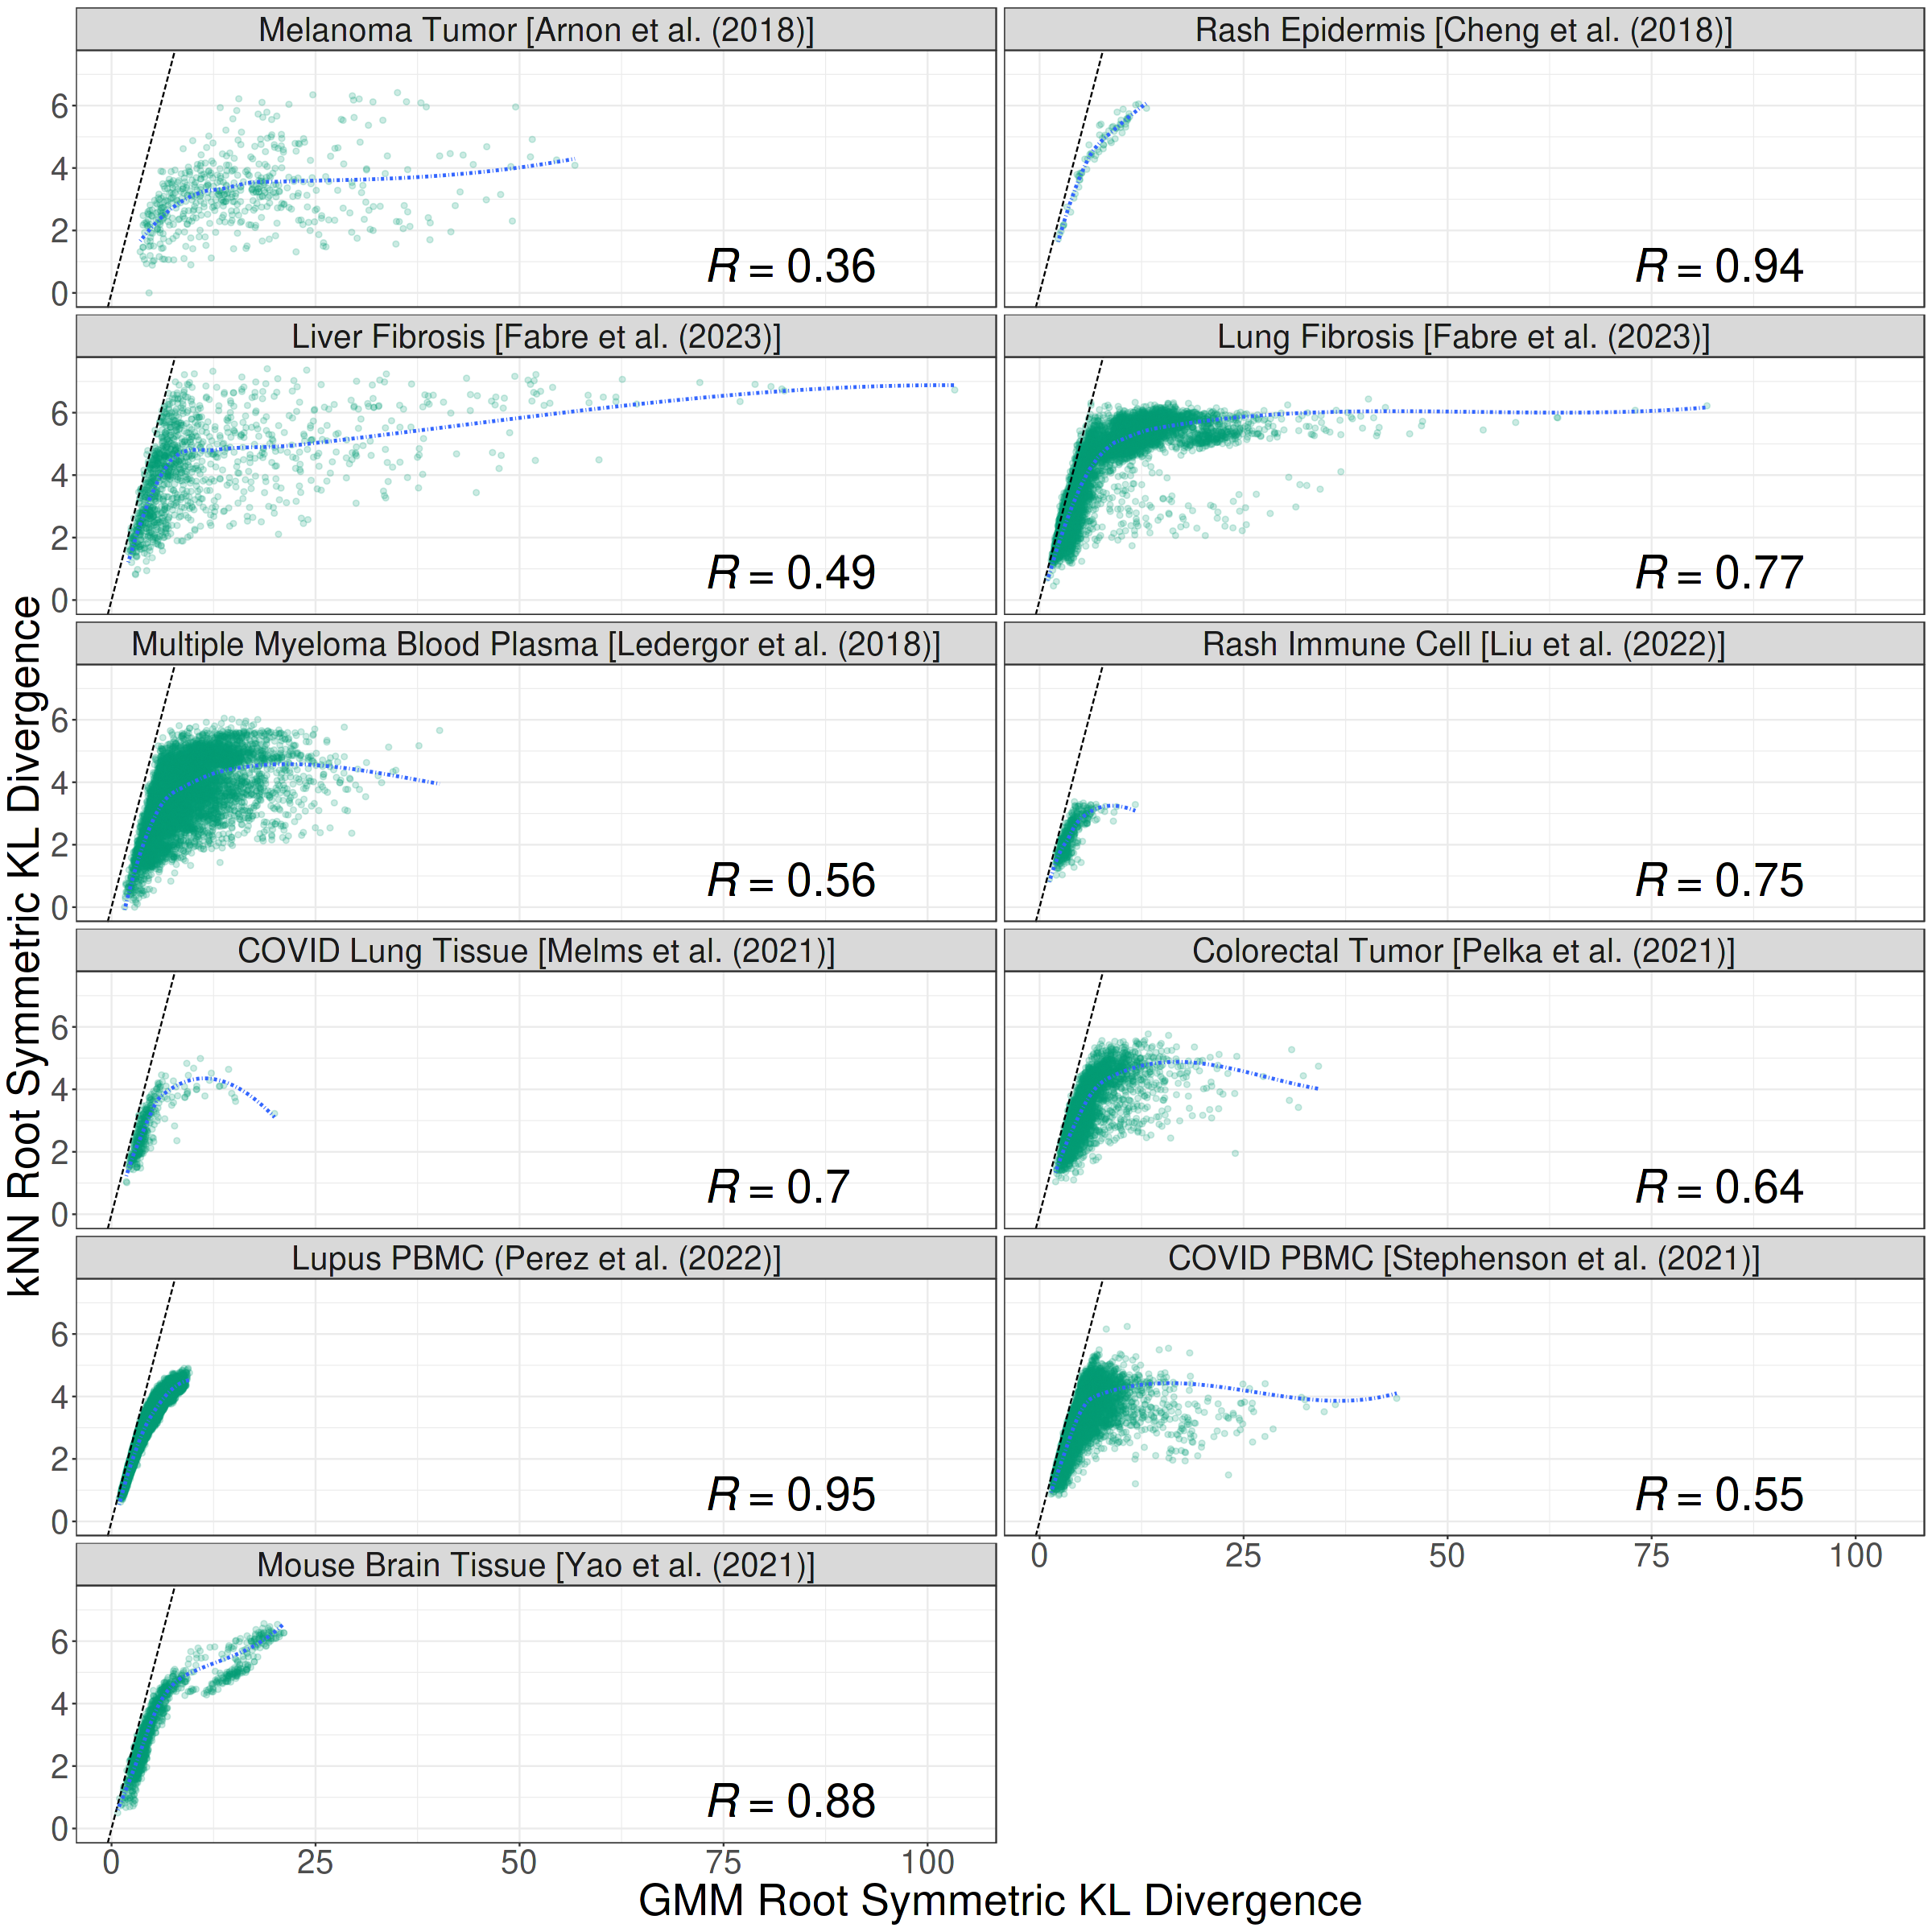

In [16]:
options(repr.plot.width=20, repr.plot.height=20)
pca_plot

In [17]:
ggsave(here::here("results","Revision","figures",paste0("realworld_summary_pca_revised.png")),height=20,width=20,device="png")

`geom_smooth()` using formula = 'y ~ x'


In [18]:
scvi_plot <- ggplot2::ggplot(distance_tibble_scvi, aes(x=baseline_distance,y=distance)) +
    geom_point(color="#009E73", alpha = 0.20) +
    geom_abline(slope = 1, intercept = 0, linetype = "longdash") +
    facet_wrap(vars(dataset), ncol=2) +
    theme_bw() +
    geom_smooth(method="loess",se=FALSE, linetype = "dotdash", fill = "#CC79A7") +
    ggpubr::stat_cor(aes(label = ggplot2::after_stat(r.label)), color = "black",# geom = "label", 
             cor.coef.name = "R", r.accuracy = 0.01, size=12, label.x.npc = 0.7, label.y.npc=0.15)+
    labs(x = paste0("GMM Root Symmetric KL Divergence"),
         y = paste0("kNN Root Symmetric KL Divergence")) +
    theme(axis.title.x = element_text(size = 32), axis.text.x = element_text(size = 24),
          axis.title.y = element_text(size = 32), axis.text.y = element_text(size = 24),
          strip.text = element_text(size = 24))   

`geom_smooth()` using formula = 'y ~ x'


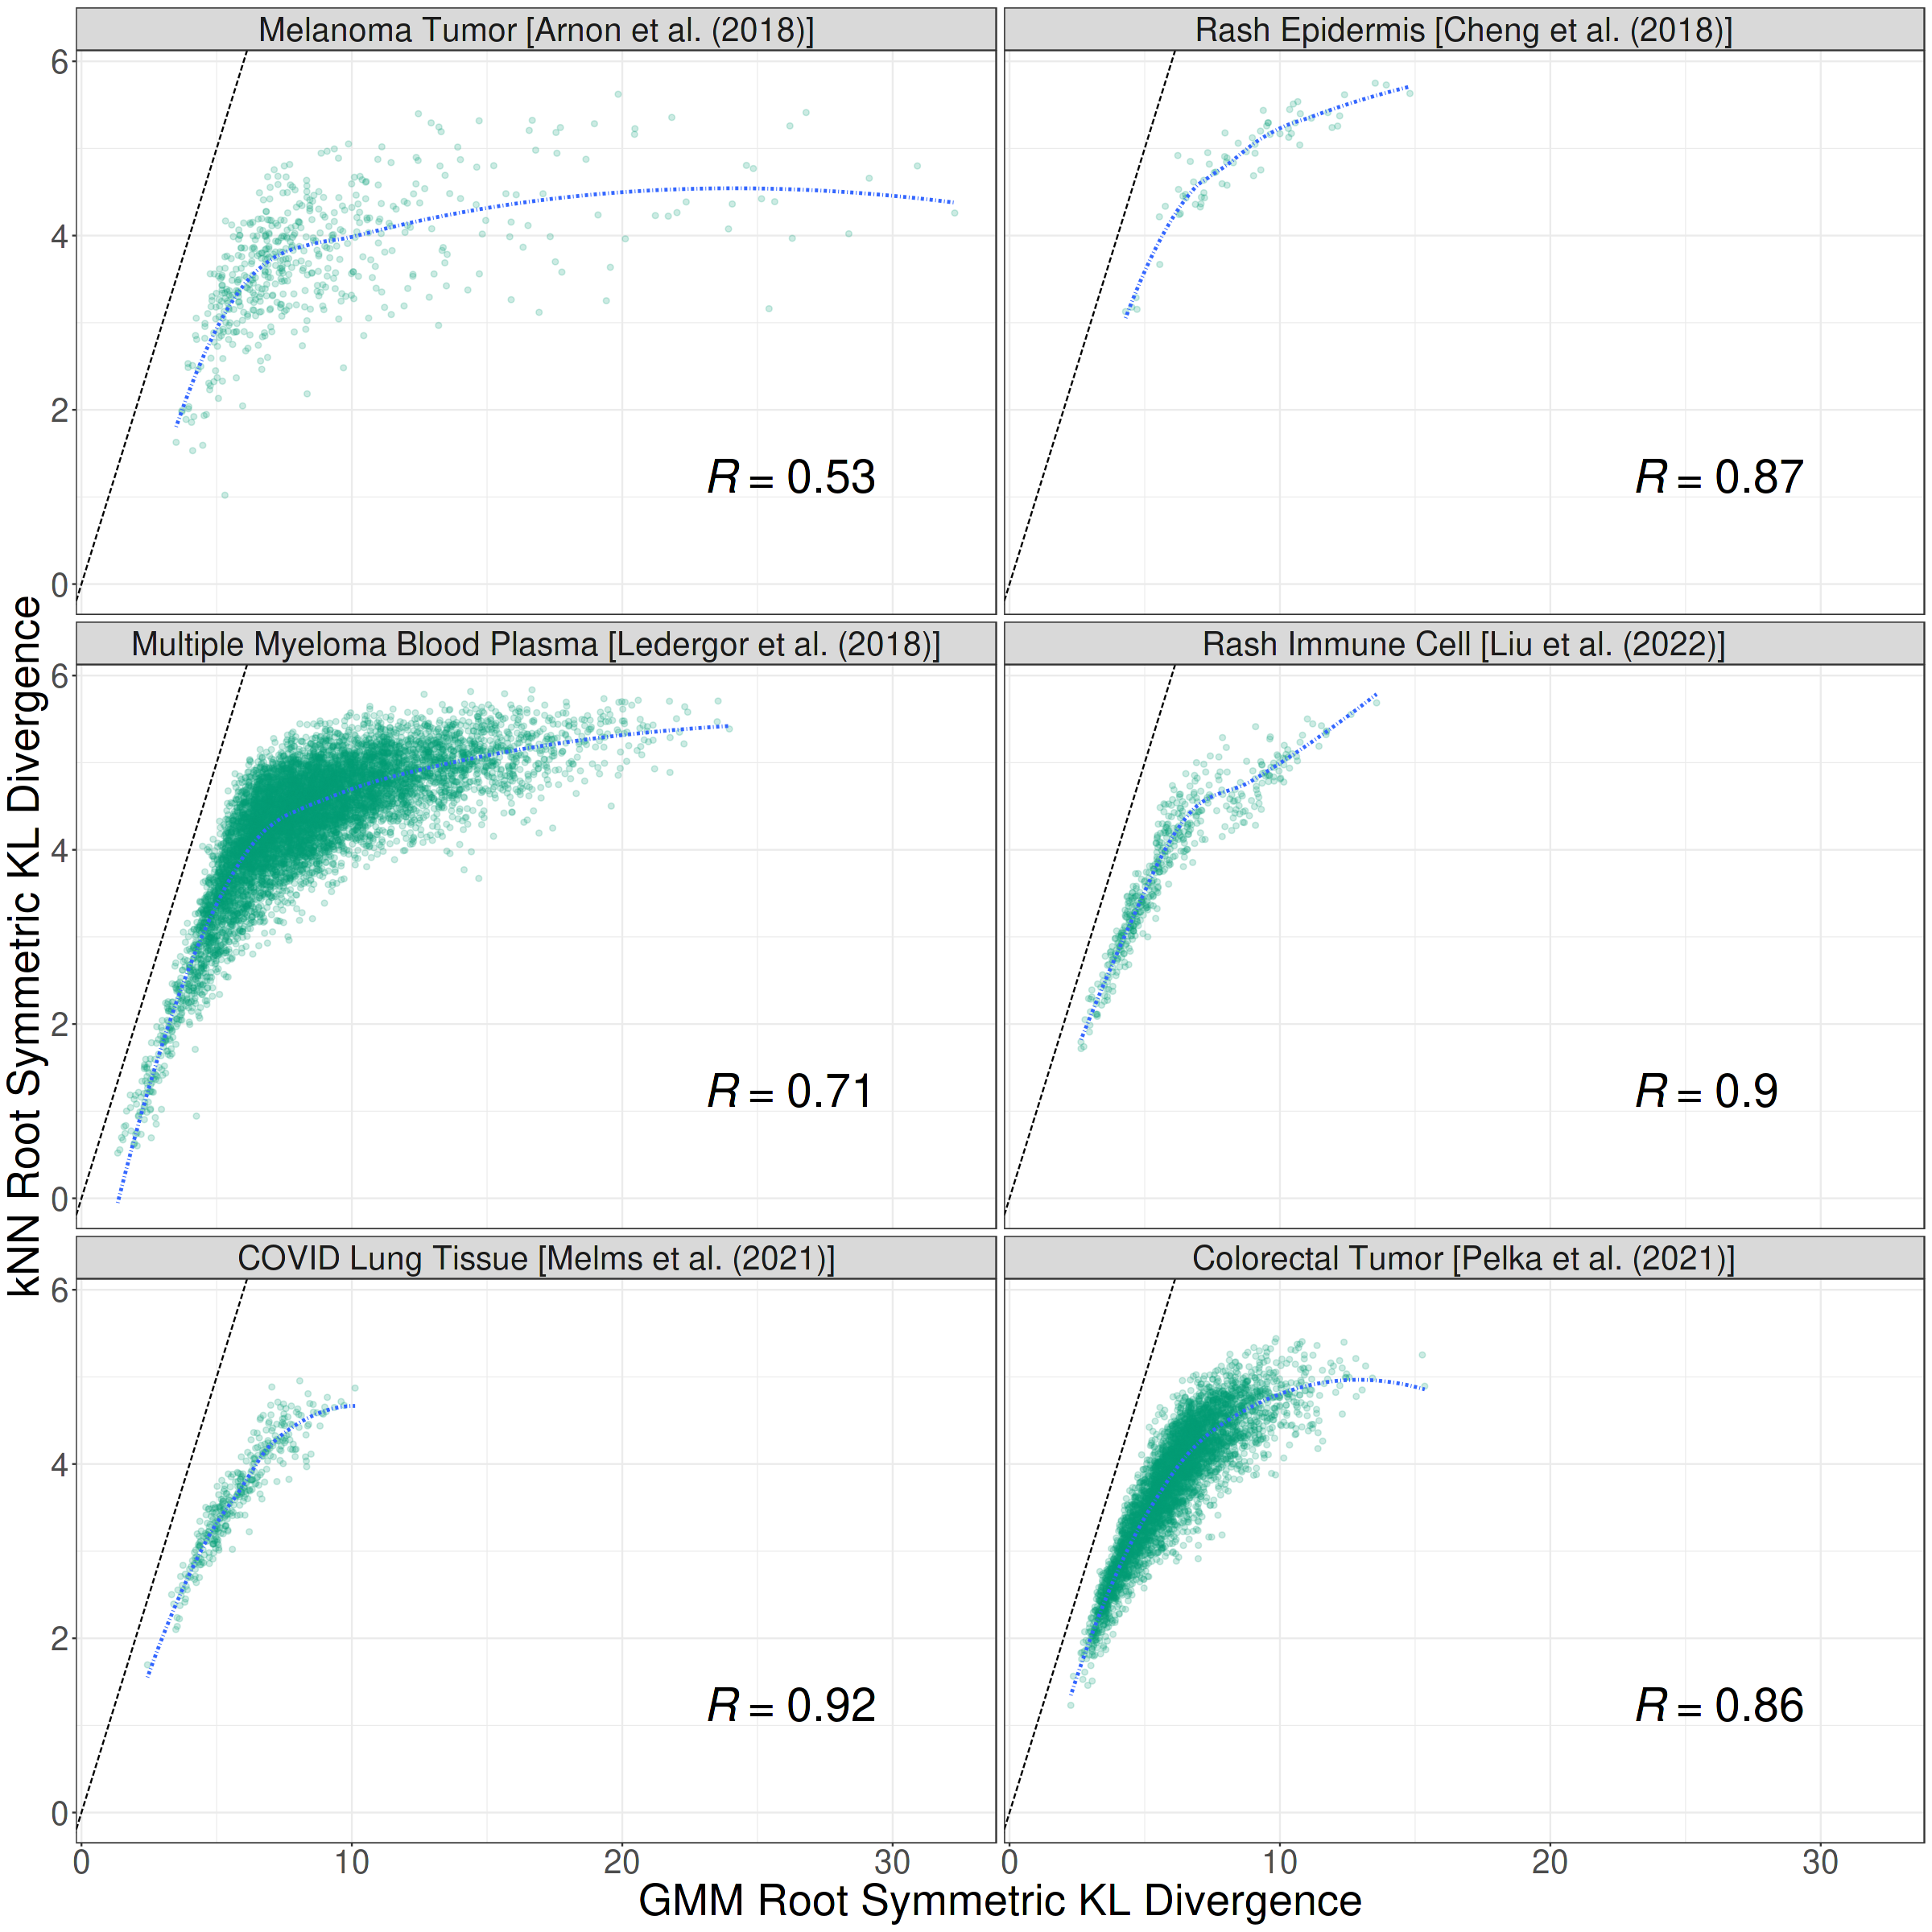

In [19]:
options(repr.plot.width=20, repr.plot.height=20)
scvi_plot

In [20]:
ggsave(here::here("results","Revision","figures",paste0("realworld_summary_scvi_revised.png")),height=20,width=20,device="png")

`geom_smooth()` using formula = 'y ~ x'
